change path to image dir

test dataset

data augmentation

cache, prefetch

overfitting

stratergy: simple model first

pipeline

MAE/MSE/RMSE

change lambda regu

In [1]:
!git clone https://github.com/LapTQ/facial_beauty_perception
%cd facial_beauty_perception/FBP5500/Images

Cloning into 'facial_beauty_perception'...
remote: Enumerating objects: 11209, done.
remote: Counting objects: 100% (11209/11209), done.
remote: Compressing objects: 100% (11194/11194), done.
remote: Total 11209 (delta 122), reused 11033 (delta 12), pack-reused 0
Receiving objects: 100% (11209/11209), 178.81 MiB | 27.29 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Checking out files: 100% (11020/11020), done.
/content/facial_beauty_perception/FBP5500/Images


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization, Conv2D, Activation, Add, Input, Dense, ZeroPadding2D, Flatten, AveragePooling2D, MaxPooling2D
from keras.initializers import he_normal
from keras.regularizers import L1, L2
from keras.models import Model

seed = 42

### Load images

In [3]:
image_size = (90, 90)
input_shape = (*image_size, 3)
batch_size = 32
scores_path = "https://github.com/LapTQ/facial_beauty_perception/raw/main/FBP5500/train_test_files/All_labels.csv"

scores_dataframe = pd.read_csv(
    scores_path,
    header=None,
    names=['file_name', 'score']
)

scores = scores_dataframe['score'].to_numpy().tolist()

In [4]:
scores_dataframe.head()

,file_name,score
0,AF1.jpg,2.333333
1,AF2.jpg,3.950000
2,AF3.jpg,3.183333
3,AF4.jpg,2.683333
4,AF5.jpg,2.000000


count    5500.000000
mean        2.990891
std         0.688112
min         1.016667
25%         2.500000
50%         2.833333
75%         3.533333
max         4.750000
Name: score, dtype: float64


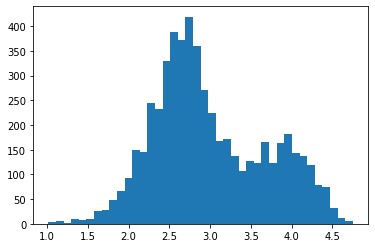

In [5]:
print(scores_dataframe['score'].describe())

plt.hist(scores_dataframe['score'], bins=40,)
plt.show()

In [6]:
images = []
for index in scores_dataframe.index:
    img = image.load_img(scores_dataframe['file_name'][index], target_size=image_size)
    img = image.img_to_array(img)
    images.append(img/255.)

In [7]:
images = np.array(images)
scores = np.array(scores)
np.random.seed(seed)
np.random.shuffle(images)
np.random.seed(seed)
np.random.shuffle(scores)

In [8]:
print(images.shape)
print(scores.shape)

(5500, 90, 90, 3)
(5500,)


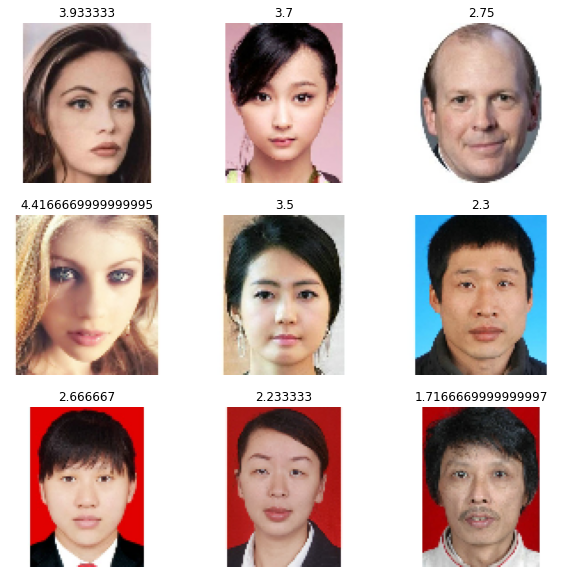

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(scores[i])
    plt.axis("off")

### Create dataset

In [10]:
n_train = 4400
v_validation = 1100
buffer_size = 5500

In [11]:
images_ds = tf.data.Dataset.from_tensor_slices(images)
scores_ds = tf.data.Dataset.from_tensor_slices(scores)

x_train = images_ds.take(n_train)
x_val = images_ds.skip(n_train)

y_train = scores_ds.take(n_train)
y_val = scores_ds.skip(n_train)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

x_val_prefetch = x_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
x_train_prefetch = x_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

y_val_prefetch = y_val.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
y_train_prefetch = y_train.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [13]:
ds = tf.data.Dataset.from_tensor_slices((images, scores))

train_ds = ds.take(n_train)
val_ds = ds.skip(n_train)

In [14]:
tiny_val_ds = val_ds.take(5).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
tiny_train_ds = train_ds.take(5).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [15]:
small_val_ds = val_ds.take(27).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
small_train_ds = train_ds.take(27).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [16]:
medium_val_ds = val_ds.take(64).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
medium_train_ds = train_ds.take(64).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [17]:
large_val_ds = val_ds.take(100).cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
large_train_ds = train_ds.take(100).cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [18]:
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### Build architectures

In [19]:
def identity_block(X, f, filters, training=True):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [20]:
def convolutional_block(X, f, filters, s=2, training=True):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [21]:
def ResNet11(input_shape=(64, 64, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_initializer=he_normal(seed=seed))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1)
    X = identity_block(X, f=3, filters=[64, 64, 256])

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_initializer=he_normal(seed=seed))(X)
    X = Dense(1, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


In [22]:
def ResNet50(input_shape=(64, 64, 3), kernel_regularizer=None, dropout=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], s=1, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[64, 64, 256], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[128, 128, 512], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[256, 256, 1024], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], s=2, kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)
    X = identity_block(X, f=3, filters=[512, 512, 2048], kernel_regularizer=kernel_regularizer, dropout=dropout)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)
    if dropout:
        X = Dropout(0.5)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=kernel_regularizer, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model

### Utilities

In [23]:
import pathlib
import tempfile
import shutil

from IPython import display

from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers


In [24]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [25]:
patience = 100      # desired
max_epochs = 1000   # desired
steps_per_epoch = n_train//batch_size

In [26]:
def get_callback(name):
    return [tf.keras.callbacks.EarlyStopping(monitor='val_nonregu_mae', patience=patience),
            tf.keras.callbacks.TensorBoard(logdir/name)
            ]

In [27]:
def compile_and_fit(model, optimizer='adam', callbacks=None, train_data=train_ds_prefetch, validation_data=val_ds_prefetch, initial_epoch=0):
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=[tf.keras.losses.MeanAbsoluteError(
            name='nonregu_mae'
        )]
    )

    np.random.seed(seed)

    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=max_epochs,
        validation_data=validation_data,
        callbacks=callbacks,
        initial_epoch=initial_epoch
    )

    return history

In [28]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4yq10h7l
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-4yq10h7l
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157855 sha256=d7a6171d8202191af0a0b6dbde3f58c40f4879c6c66fcc85b4944b129d478c3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_m91ozt/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [29]:
plotter = tfdocs.plots.HistoryPlotter(
    metric = 'nonregu_mae',
    smoothing_std=10
)

In [30]:
def loss(model, x, y, training=False):
    mae = tf.keras.losses.MeanAbsoluteError()
    y_pred = model(x, training=training)
    return mae(y_true=y, y_pred=y_pred)

def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Testing

#### plot activation distribution

In [ ]:
model = ResNet11(input_shape)
optimizer = Adam(learning_rate=1e-5)        # try 1e-2 the loss goes up

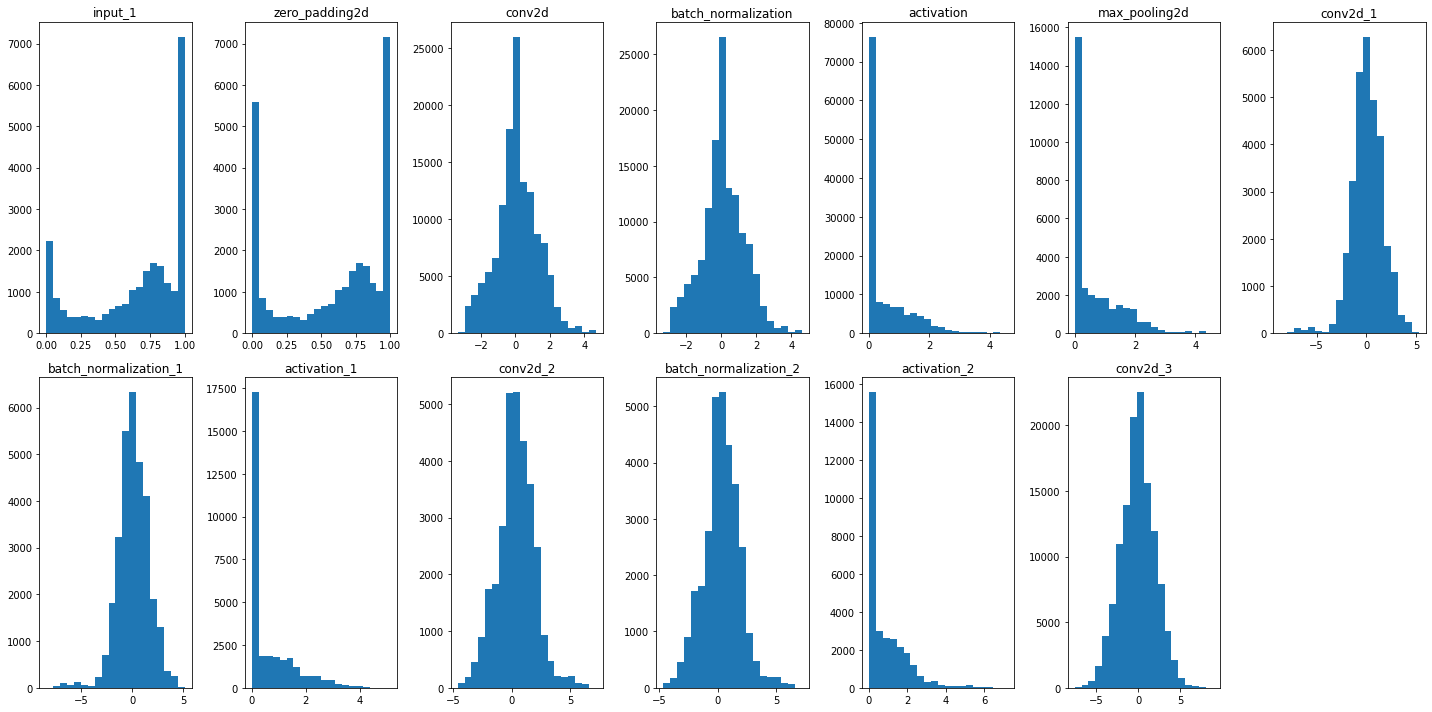

In [ ]:
def plot_activations(model, img):
    """
    Arguments:
        model
        img -- numpy array of shape (height, width, channel)
    """
    activations = [model.layers[0](np.expand_dims(img, axis=0))]      # Input layer
    for layer in model.layers[1:13]:         # 14th layer not match input shape because of shortcut
        # print("Inputing shape: {} to {} with expected input shape: {}".format(activations[-1].shape, layer.name, layer.input_shape))
        activations.append(layer(activations[-1], training=False))

    # plot activation distribution
    plt.figure(figsize=(20, 10))
    for i in range(len(activations)):
        plt.subplot(2, 7, i + 1)
        plt.title(model.layers[i].name)
        plt.tight_layout()
        plt.hist(activations[i].numpy().reshape(-1,), bins=20)

plot_activations(model, images[1])

#### make sure can overfit

In [ ]:
resnet11_histories = {}

In [ ]:
# make sure the model can overfit on very small dataset
model = ResNet11(input_shape)
optimizer = Adam(learning_rate=1e-5)        # try 1e-2 the loss goes up

steps_per_epoch = 5

resnet11_histories['history_11_tiny'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
)

clearly that the model overfit ;)) so it works

ResNet11 work very well for tiny data set.

Let's try with a small data set.

The loss will be larger (as learning curve) if we keep configuration unchanged (eg. lr).

If we change configuration (eg lr) but cannot get a better loss, than our model might be underfit. So we'll try a bigger model for small dataset

Repeat that

now, let's try with a small data set with Adam

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 27

resnet11_histories['history_11_small'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-5),
    train_data=small_train_ds,
    validation_data=small_val_ds
)

Note: figure plotted above

We clearly see that for a bigger dataset,
* the training loss if higher
* the val loss is smaller

=> follow learning curve principle

Let' try with medium dataset

In [ ]:
model = ResNet11(input_shape)

steps_per_epoch = 64

resnet11_histories['history_11_medium'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=medium_train_ds,
    validation_data=medium_val_ds
)

still overfit quite well, the training loss even better than for small and tiny, might be because of the smaller leanrning rate

Let' try with large dataset

In [ ]:
model = ResNet11(input_shape)

max_epochs = 20
steps_per_epoch = 100

resnet11_histories['history_11_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=large_train_ds,
    validation_data=large_val_ds
)

still overfit quite well

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=5e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

full data set seem much worse on train set, but val loss smaller => follow the learning curve

Let's try tuning for a larger lr:

large: 5e-6: slow, 0.3...

lr2: 1e-6: slower, 0.35... vẫn đang đi xuống

lr: 5e-5: slower, 0.4... có dấu hiệu đi lên



có khi xem xét dùng peicewise

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['history_11_very_large_tune_lr2'] = compile_and_fit(
    model,
    optimizer=Adam(learning_rate=1e-6),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

the lr = 5e-6 seems the most optimistic among 3 stratergy.

in the saddle point of training loss plot: 2 reasons:

* reason 1: learning rate is large for that saddle point: Let's try using piecewise constant decay or inverse time decay
* reason 2: saddle point in the obj function: adam, momentum...

combine with training longer

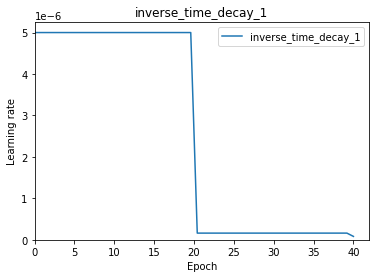

In [ ]:
inverse_time_decay_1 = InverseTimeDecay(
    initial_learning_rate=5e-6,
    decay_steps=steps_per_epoch*20,
    decay_rate=30,
    staircase=True,
    name='inverse_time_decay_1'
)

step = np.linspace(0, steps_per_epoch * max_epochs)

plot_learning_rate(step, inverse_time_decay_1)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet11_histories['inverse_time_decay_1'] = compile_and_fit(
    model,
    optimizer=Adam(inverse_time_decay_1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

Text(0.5, 0, 'Epochs')

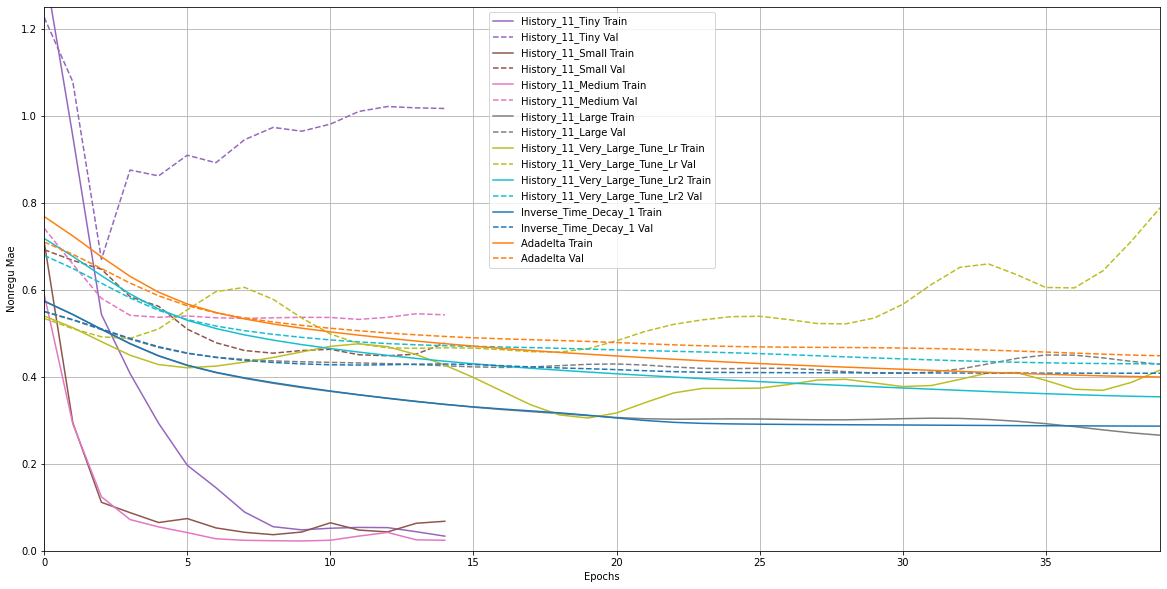

In [ ]:
plt.figure(figsize=(20, 10))
plotter.plot(resnet11_histories)
# a = plt.xscale('log')
plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 1.25])
plt.xlabel('Epochs')        # <---- add [Log scale]

had already tried many cofiguration for inverse tme decay but still not work, let's try other optimization algo

In [ ]:
resnet_11_adadelta_histories = {}

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr1'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr2'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-1),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
model = ResNet11(input_shape)

max_epochs = 40
steps_per_epoch = 137

resnet_11_adadelta_histories['lr3'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=1e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# this one work best
model = ResNet11(input_shape)

max_epochs = 200
steps_per_epoch = 137

resnet_11_adadelta_histories['lr4'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-2),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

In [ ]:
# lr5: continue lr4, but with smaller lr = 5e-3
# model = ResNet11(input_shape)

max_epochs = 100
steps_per_epoch = 137

resnet_11_adadelta_histories['lr5'] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=5e-3),
    train_data=train_ds_prefetch,
    validation_data=val_ds_prefetch
)

ohhh, so after 200 epochs of Adadelta with lr = 5e-2, we train on another 100 epochs with lr = 5e-3 show a very optimistic future :))

Text(0.5, 0, 'Epochs')

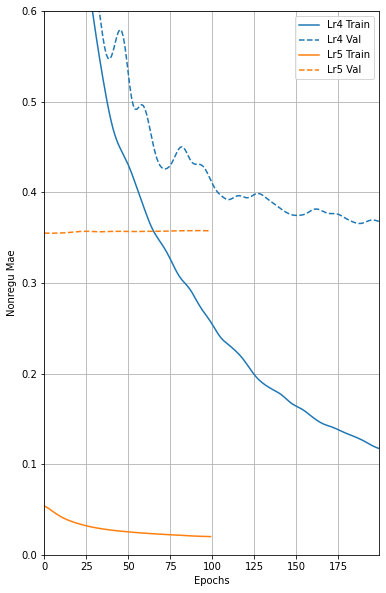

In [ ]:
plt.figure(figsize=(6, 10))
plotter.plot(resnet_11_adadelta_histories)
# a = plt.xscale('log')
# plt.xlim([0, max(plt.xlim())])
plt.ylim([0, 0.6])
plt.xlabel('Epochs')        # <---- add [Log scale]

Now we're confident that the model can overfit the dataset, if I keep training, the loss might be smaller (I GUESS SO :>)

Let's use regularization!!!

#### build regu architecture

In [31]:
l = L2(0.001)

In [32]:
def identity_block_regu(X, f, filters, training=True, dropout_rate=0):
    """
    Implementation of the identity block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # add shortcut value to main path and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

    

In [33]:
def convolutional_block_regu(X, f, filters, s=2, training=True, dropout_rate=0):
    """
    Implementation of the convolutional block
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # retrieve filters
    F1, F2, F3 = filters

    # save the input value
    X_shortcut = X

    # first component of main path
    X = Conv2D(F1, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # second component of main path
    X = Conv2D(F2, kernel_size=f, strides=1, padding='same', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)

    # third component of main path
    X = Conv2D(F3, kernel_size=1, strides=1, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X, training=training)

    # shortcut path
    X_shortcut = Conv2D(F3, kernel_size=1, strides=s, padding='valid', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X_shortcut)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X_shortcut = BatchNormalization(axis=3)(X_shortcut, training=training)

    # add shortcut to main path, and pass it through a RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [34]:
def ResNet11_regu(input_shape=(64, 64, 3), dropout_rate=0):

    X_input = Input(input_shape)

    X = ZeroPadding2D(padding=3)(X_input)

    # define the input as a tensor
    X_input= Input(input_shape)

    # zero-padding
    X = ZeroPadding2D(padding=3)(X_input)

    # stage 1
    X = Conv2D(filters=64, kernel_size=7, strides=2, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=3, strides=2)(X)

    # stage 2
    X = convolutional_block_regu(X, f=3, filters=[64, 64, 256], s=1, dropout_rate=dropout_rate)
    X = identity_block_regu(X, f=3, filters=[64, 64, 256], dropout_rate=dropout_rate)

    # average pooling layer
    X = AveragePooling2D(pool_size=2, strides=1, name="avg_pool")(X)
    X = Flatten()(X)
    X = Dense(4, activation='relu', kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)
    X = Dropout(dropout_rate)(X)     # <---- need training=training???
    X = Dense(1, kernel_regularizer=l, kernel_initializer=he_normal(seed=seed))(X)

    # create model
    model = Model(inputs=X_input, outputs=X)

    return model


#### testing

In [ ]:
# Testing learning rate
l = L2(0.001)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)


loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.7346019


In [ ]:
# check if the regu term is present

model.layers[2].get_config()

first, we check with tiny dataset

if the training is terminated because of callback, adjust the learning rate to smaller



In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 20
steps_per_epoch = 5


lr = 1e-4
name = 'regu_0.001_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

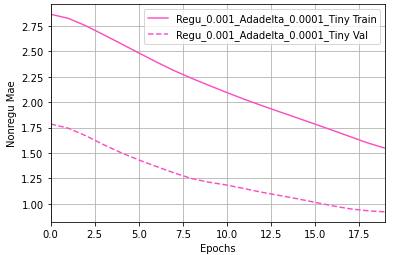

với 20 epochs fit khá tốt với tiny. nếu train thêm chắc sẽ overfit được

#### thử với lamda = 0.001

In [ ]:
resnet_11_regu_histories = {}

In [ ]:
l = L2(0.001)

patience = 10
max_epochs = 50
steps_per_epoch = 137

lr = 1e-4


name = 'regu_0.001_adadelta'
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

In [ ]:
patience = 30
max_epochs = 400

lr = 1e-4


# shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_regu_histories[name].epoch[-1]
)

lr_record.append(lr)
epoch_record.append(cont_history.epoch[-1])
resnet_11_regu_histories[name].epoch += cont_history.epoch
resnet_11_regu_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_regu_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_regu_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_regu_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

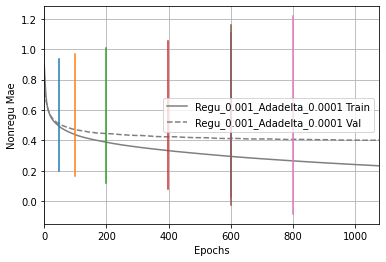

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

có vẻ không ổn lắm vì khoảng cách bắt đầu xa

#### Thử với lambda = 0.01

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(0.01)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978876
0.73460203


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 466ms/step - loss: 24.5259 - nonregu_mae: 2.5810 - val_loss: 23.3164 - val_nonregu_mae: 1.3717
Epoch 2/20
5/5 [==============================] - 1s 269ms/step - loss: 23.8404 - nonregu_mae: 1.8958 - val_loss: 22.8131 - val_nonregu_mae: 0.8686
Epoch 3/20
5/5 [==============================] - 1s 271ms/step - loss: 23.2852 - nonregu_mae: 1.3408 - val_loss: 22.5252 - val_nonregu_mae: 0.5810
Epoch 4/20
5/5 [==============================] - 1s 266ms/step - loss: 22.7732 - nonregu_mae: 0.8291 - val_loss: 22.4501 - val_nonregu_mae: 0.5062
Epoch 5/20
5/5 [==============================] - 1s 260ms/step - loss: 22.5949 - nonregu_mae: 0.6512 - val_loss: 22.5185 - val_nonregu_mae: 0.5750
Epoch 6/20
5/5 [==============================] - 1s 262ms/step - loss: 22.4983 - nonregu_mae: 0.5550 - val_loss: 22.5787 - val_nonregu_mae: 0.6357
Epoch 7/20
5/5 [==============================] - 1s 259ms/step - loss: 22.4012 - nonregu_mae: 0.4584 - val_loss

Text(0.5, 0, 'Epochs')

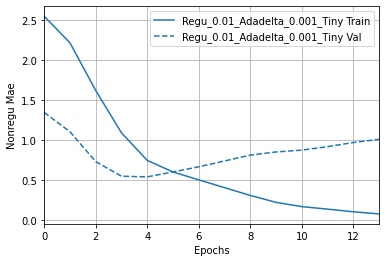

In [ ]:
l = L2(0.01)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_0.01_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
l = L2(0.01)

patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

lr = 1e-3


name = 'regu_0.01_adadelta'
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

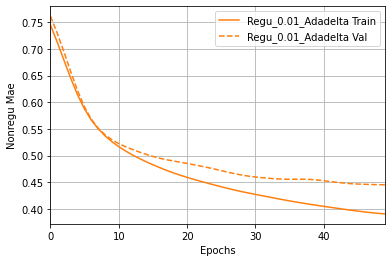

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

lambda = 0.01 trông vẫn tệ, thử cái lớn hơn xem sao

#### thử lambda = 0.1

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(0.1)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978877
0.73460186


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 472ms/step - loss: 222.0275 - nonregu_mae: 2.5825 - val_loss: 220.8102 - val_nonregu_mae: 1.3724
Epoch 2/20
5/5 [==============================] - 1s 263ms/step - loss: 221.3324 - nonregu_mae: 1.9000 - val_loss: 220.2935 - val_nonregu_mae: 0.8694
Epoch 3/20
5/5 [==============================] - 1s 267ms/step - loss: 220.7667 - nonregu_mae: 1.3483 - val_loss: 219.9922 - val_nonregu_mae: 0.5824
Epoch 4/20
5/5 [==============================] - 1s 263ms/step - loss: 220.2397 - nonregu_mae: 0.8358 - val_loss: 219.9009 - val_nonregu_mae: 0.5066
Epoch 5/20
5/5 [==============================] - 1s 262ms/step - loss: 220.0424 - nonregu_mae: 0.6548 - val_loss: 219.9508 - val_nonregu_mae: 0.5734
Epoch 6/20
5/5 [==============================] - 1s 257ms/step - loss: 219.9300 - nonregu_mae: 0.5595 - val_loss: 219.9937 - val_nonregu_mae: 0.6335
Epoch 7/20
5/5 [==============================] - 1s 263ms/step - loss: 219.8182 - nonregu_mae: 0.46

Text(0.5, 0, 'Epochs')

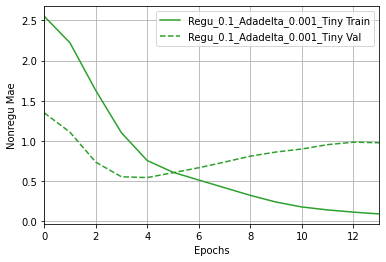

In [ ]:
l = L2(0.1)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_0.1_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

l = L2(0.1)
name = 'regu_0.1_adadelta'
lr = 1e-3


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

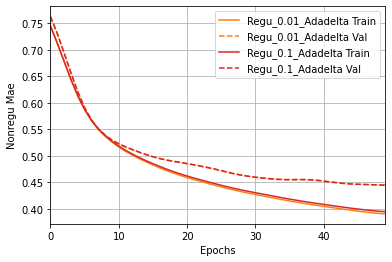

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

#### thử lambda = 1

In [ ]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Testing learning rate
l = L2(1)

# model without dropout
model = ResNet11_regu(input_shape)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.3670883
1.2978876
0.734602


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 481ms/step - loss: 2197.0098 - nonregu_mae: 2.5906 - val_loss: 2195.6785 - val_nonregu_mae: 1.3766
Epoch 2/20
5/5 [==============================] - 1s 264ms/step - loss: 2196.1431 - nonregu_mae: 1.9219 - val_loss: 2194.9719 - val_nonregu_mae: 0.8734
Epoch 3/20
5/5 [==============================] - 1s 265ms/step - loss: 2195.4121 - nonregu_mae: 1.3962 - val_loss: 2194.4854 - val_nonregu_mae: 0.5944
Epoch 4/20
5/5 [==============================] - 1s 263ms/step - loss: 2194.6990 - nonregu_mae: 0.8922 - val_loss: 2194.1768 - val_nonregu_mae: 0.4971
Epoch 5/20
5/5 [==============================] - 1s 266ms/step - loss: 2194.2651 - nonregu_mae: 0.6724 - val_loss: 2194.0388 - val_nonregu_mae: 0.5776
Epoch 6/20
5/5 [==============================] - 1s 260ms/step - loss: 2193.9602 - nonregu_mae: 0.5876 - val_loss: 2193.8801 - val_nonregu_mae: 0.6405
Epoch 7/20
5/5 [==============================] - 1s 263ms/step - loss: 2193.6543 - nonr

Text(0.5, 0, 'Epochs')

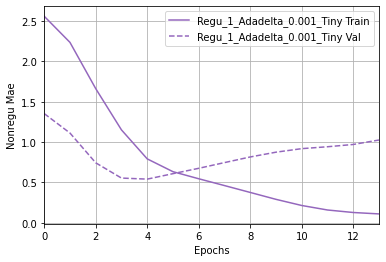

In [ ]:
l = L2(1)

patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 1e-3

name = 'regu_1_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [ ]:
# resnet_11_regu_histories = {}

In [ ]:
patience = 10
max_epochs = 50
steps_per_epoch = n_train // batch_size

l = L2(1)
name = 'regu_1_adadelta'
lr = 1e-3

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

Text(0.5, 0, 'Epochs')

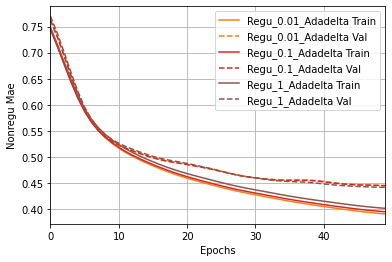

In [ ]:
# plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

sao tệ thế nhỉ, thử dropout xem sao

#### thử dropout + L2

In [ ]:
l = None

# model without dropout
model = ResNet11_regu(input_shape, dropout_rate=0.5)

optimizer = Adadelta(learning_rate=1e-2)

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

optimizer.apply_gradients(zip(gradients, model.trainable_variables))

loss_value, gradients = grad(model, images[:500], scores[:500])

print(loss_value.numpy())

2.4328966
1.9771545
1.9397348


try overfit on tiny

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 466ms/step - loss: 3.0556 - nonregu_mae: 3.0556 - val_loss: 1.5270 - val_nonregu_mae: 1.5270
Epoch 2/20
5/5 [==============================] - 1s 272ms/step - loss: 2.8212 - nonregu_mae: 2.8212 - val_loss: 1.1424 - val_nonregu_mae: 1.1424
Epoch 3/20
5/5 [==============================] - 1s 274ms/step - loss: 2.6440 - nonregu_mae: 2.6440 - val_loss: 0.8369 - val_nonregu_mae: 0.8369
Epoch 4/20
5/5 [==============================] - 1s 273ms/step - loss: 2.4692 - nonregu_mae: 2.4692 - val_loss: 0.7163 - val_nonregu_mae: 0.7163
Epoch 5/20
5/5 [==============================] - 1s 280ms/step - loss: 2.1561 - nonregu_mae: 2.1561 - val_loss: 0.6747 - val_nonregu_mae: 0.6747
Epoch 6/20
5/5 [==============================] - 1s 272ms/step - loss: 2.1896 - nonregu_mae: 2.1896 - val_loss: 0.6490 - val_nonregu_mae: 0.6490
Epoch 7/20
5/5 [==============================] - 1s 272ms/step - loss: 2.1380 - nonregu_mae: 2.1380 - val_loss: 0.6290 - va

Text(0.5, 0, 'Epochs')

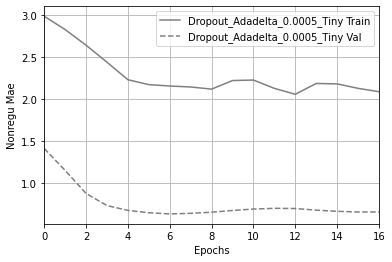

In [ ]:
patience = 10
max_epochs = 20
steps_per_epoch = 5

lr = 5e-4

name = 'dropout_adadelta_{}_tiny'.format(lr)
shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape, dropout_rate=0.5)

history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    train_data=tiny_train_ds,
    validation_data=tiny_val_ds,
    callbacks=get_callback('optimizers/' + name)
)

plotter.plot({name: history})
plt.xlabel('Epochs')        # <---- add [Log scale]

In [82]:
batch_size = 64
val_ds_prefetch = val_ds.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_ds_prefetch = train_ds.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# resnet_11_regu_histories = {}

In [72]:
patience = 125   # 10?
max_epochs = 700
steps_per_epoch = n_train // batch_size

l = L2(0.01)
name = 'dropout_0.01_adadelta'
lr = 5e-2


shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)
model = ResNet11_regu(input_shape, dropout_rate=0.5)

resnet_11_regu_histories[name] = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name)
)

lr_record = [lr]
epoch_record = [resnet_11_regu_histories[name].epoch[-1]]

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/700
68/68 [==============================] - 7s 77ms/step - loss: 23.2093 - nonregu_mae: 1.5729 - val_loss: 21.9898 - val_nonregu_mae: 0.6966
Epoch 2/700
68/68 [==============================] - 4s 65ms/step - loss: 22.4699 - nonregu_mae: 1.5394 - val_loss: 21.6084 - val_nonregu_mae: 1.0670
Epoch 3/700
68/68 [==============================] - 4s 65ms/step - loss: 21.6893 - nonregu_mae: 1.5405 - val_loss: 20.8591 - val_nonregu_mae: 1.1267
Epoch 4/700
68/68 [==============================] - 4s 64ms/step - loss: 20.8983 - nonregu_mae: 1.5753 - val_loss: 20.0341 - val_nonregu_mae: 1.1409
Epoch 5/700
68/68 [==============================] - 4s 65ms/step - loss: 19.9708 - nonregu_mae: 1.4947 - val_loss: 18.5820 - val_nonregu_mae: 0.5373
Epoch 6/700
68/68 [==============================] - 4s 65ms/step - loss: 19.1783 - nonregu_mae: 1.5558 - val_loss: 18.0775 - val_nonregu_mae: 0.8893
Epoch 7/700
68/68 [==============================] - 4s 65ms/step - loss: 18.3248 - nonregu_mae: 1.5

'/content/facial_beauty_perception/saved_model.zip'

In [93]:
patience = 30
max_epochs = 900

lr = 1e-1

shutil.rmtree(logdir/("optimizers/" + name), ignore_errors=True)

cont_history = compile_and_fit(
    model,
    optimizer=Adadelta(learning_rate=lr),
    callbacks=get_callback('optimizers/' + name),
    initial_epoch=resnet_11_regu_histories[name].epoch[-1]
)

epoch_record.append(cont_history.epoch[-1])
lr_record.append(lr)
resnet_11_regu_histories[name].epoch += cont_history.epoch
resnet_11_regu_histories[name].history['loss'] += cont_history.history['loss']
resnet_11_regu_histories[name].history['val_loss'] += cont_history.history['val_loss']
resnet_11_regu_histories[name].history['nonregu_mae'] += cont_history.history['nonregu_mae']
resnet_11_regu_histories[name].history['val_nonregu_mae'] += cont_history.history['val_nonregu_mae']

model.save_weights('/content/facial_beauty_perception/saved_model/saved_model')
shutil.make_archive('/content/facial_beauty_perception/saved_model', 'zip', '/content/facial_beauty_perception/saved_model')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 817/900
68/68 [==============================] - 7s 78ms/step - loss: 0.4617 - nonregu_mae: 0.4288 - val_loss: 0.4001 - val_nonregu_mae: 0.3649
Epoch 818/900
68/68 [==============================] - 4s 65ms/step - loss: 0.4655 - nonregu_mae: 0.4320 - val_loss: 0.4175 - val_nonregu_mae: 0.3812
Epoch 819/900
68/68 [==============================] - 4s 64ms/step - loss: 0.4509 - nonregu_mae: 0.4170 - val_loss: 0.4010 - val_nonregu_mae: 0.3644
Epoch 820/900
68/68 [==============================] - 4s 65ms/step - loss: 0.4791 - nonregu_mae: 0.4449 - val_loss: 0.4207 - val_nonregu_mae: 0.3841
Epoch 821/900
68/68 [==============================] - 4s 65ms/step - loss: 0.4424 - nonregu_mae: 0.4079 - val_loss: 0.3951 - val_nonregu_mae: 0.3569
Epoch 822/900
68/68 [==============================] - 4s 65ms/step - loss: 0.4705 - nonregu_mae: 0.4355 - val_loss: 0.3919 - val_nonregu_mae: 0.3536
Epoch 823/900
68/68 [==============================] - 4s 65ms/step - loss: 0.4606 - nonregu_mae: 0.

'/content/facial_beauty_perception/saved_model.zip'

nguyên nhân:

* lr lớn, cần giảm ===> đã thử lr bé rất nhiều nhưng không thể hạ thấp hơn đc
* saddle point
* model capacity

thử dùng giải thuật khác xem sao

[0.05, 0.001, 1e-06, 0.1]


Text(0.5, 0, 'Epochs')

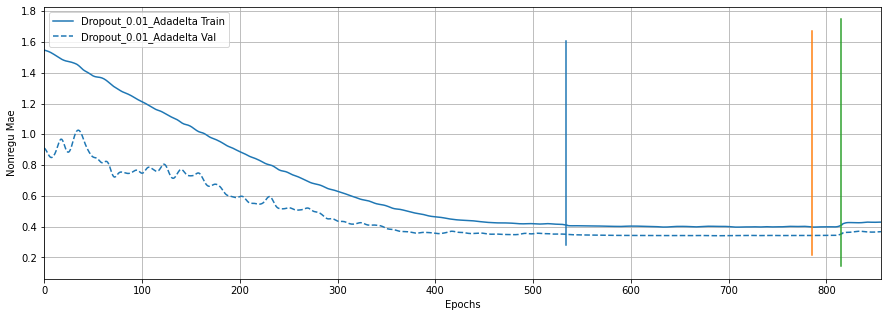

In [94]:
print(lr_record)

plt.figure(figsize=(15, 5))
plotter.plot(resnet_11_regu_histories)
for i in range(len(epoch_record) - 1):
    plt.plot([epoch_record[i] - 1, epoch_record[i] - 1], plt.ylim())
# a = plt.xscale('log')
# plt.xlim([0, 40])
# plt.ylim([0, 0.7])
plt.xlabel('Epochs')        # <---- add [Log scale]

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {logdir}/lr

In [ ]:
predictions = tf.data.Dataset.from_tensor_slices(model.predict(val_ds_prefetch)).batch(batch_size)

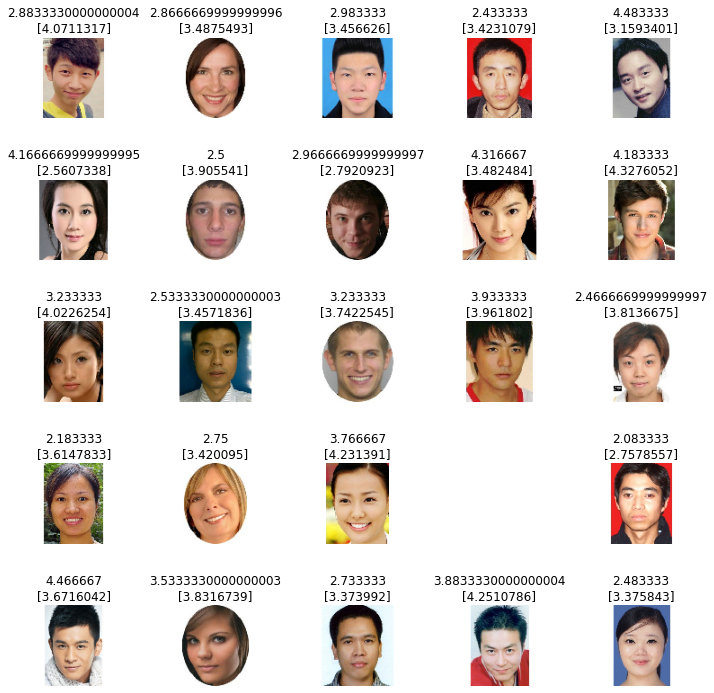

In [ ]:
plt.figure(figsize=(10, 10))
for images, true_scores in val_ds_prefetch.take(1):
    for pred_scores in predictions.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i])
            plt.title('{}\n{}'.format(true_scores[i], pred_scores[i]))
            plt.tight_layout()
            plt.axis("off")